# Detecção de Mudanças

Escolhendo uma cidade: Águas Claras


In [1]:
import glob
from skimage import io
import matplotlib.pyplot as plt
import numpy as np


def get_spectral_band_from_image_name(image_name):
    '''
    
    Exemplo de nome de imagem: S2A_OPER_MSI_L1C_TL_SGS__20160927T081713_A006607_T49QHE_B01.tif
    '''
    import re

    match = re.search(r"_(B[\da-zA-Z]{2})\.tif", image_name, re.I)
    if (match == None):
        return None
    return match.group(1)


def import_all_files_from_directory(path):
    '''
    Carrega todas as imagens do diretório especificado.
    Retorna, para cada imagem, uma tupla contendo:
        - um np.ndarray com seu conteúdo
        - uma string informando a banda espectral amostrada na imagem
    '''
    images = []
    for filename in glob.glob('{}/*.tif'.format(path)):
        image = io.imread(filename)
        band = get_spectral_band_from_image_name(filename)
        images.append((image, band))

    return images

def show_all_bands(images, title=''):
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, image in enumerate(images):
        axes[i].imshow(image[0])
        axes[i].set_title('{} [{}] {}'.format(title, image[1], image[0].shape))

    for ax in axes:
        ax.set_axis_off()
    
    plt.show()

def show_compare(left, right, left_title='', right_title=''):
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(18, 12))
    left_ax.imshow(left)
    left_ax.set_axis_off()
    left_ax.set_title('{} {}'.format(left_title, left.shape))
    right_ax.imshow(right)
    right_ax.set_axis_off()
    right_ax.set_title('{} {}'.format(right_title, right.shape))
    plt.show()
    
def show(image):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.imshow(image)
    ax.set_axis_off()
    plt.show()
    
aguasclaras_sources = import_all_files_from_directory('onera-images/aguasclaras/imgs_1')
aguasclaras_targets = import_all_files_from_directory('onera-images/aguasclaras/imgs_2')
aguasclaras_ground_truth = io.imread('onera-labels/aguasclaras/cm/cm.png')[:, :, 0]
show_all_bands(aguasclaras_sources, 'Águas Claras t1') 


<Figure size 1800x1000 with 15 Axes>

Reescalando todas as bandas para que tenham o mesmo tamanho (da maior)

In [2]:
from skimage.transform import rescale

def rescale_bands(image_sources):
    largest_shape = max(list(map(lambda band_tuple: band_tuple[0].shape, image_sources)))
    largest_shape = largest_shape + (len(image_sources),)
    single_image = np.ndarray(largest_shape)
    for i, band in enumerate(image_sources):
        rescale_ratio = largest_shape[0] / band[0].shape[0]
        single_image[:, :, i] = rescale(band[0], rescale_ratio, anti_aliasing=True)

    return single_image  
    

aguasclaras_single_image_t1 = rescale_bands(aguasclaras_sources)
aguasclaras_single_image_t2 = rescale_bands(aguasclaras_targets)


/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


## Resolvendo com _image differencing_

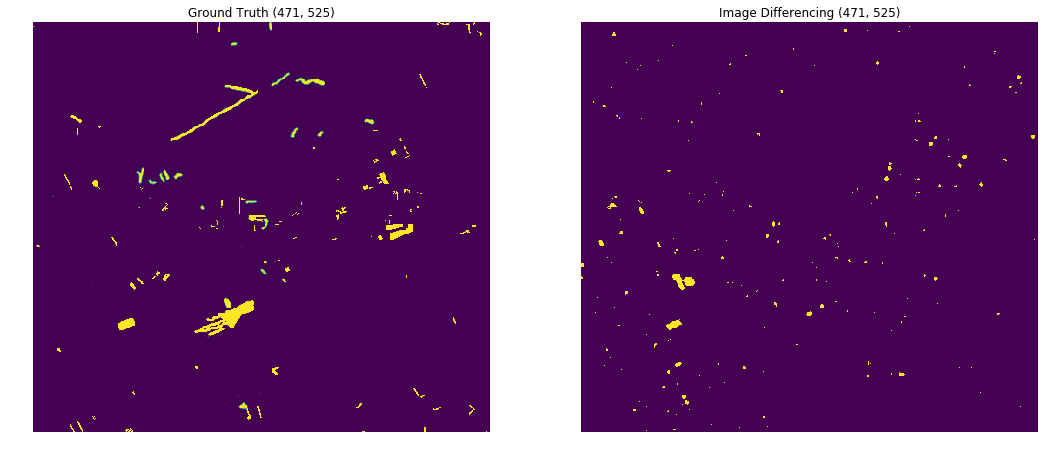

In [3]:
def generate_image_differencing(time1, time2, threshold=0.035):
    difference_image = abs(time1 - time2)
    binary_image = np.ndarray((time1.shape[0], time1.shape[1]))
    binary_image = np.any(difference_image[:, :] > threshold, axis=2)
    binary_image = binary_image.astype('float')
    return binary_image

aguasclaras_difference_image = generate_image_differencing(aguasclaras_single_image_t1, aguasclaras_single_image_t2)
show_compare(aguasclaras_ground_truth, aguasclaras_difference_image, 'Ground Truth', 'Image Differencing')


Comparando com o _ground truth_

Cidade               Image Differencing (ssim) Image Differencing (acc) 
aguasclaras          0.9244783015601045        0.9765645536346174       


/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


## Resolvendo com PCA, segmentação e LBP

Gerando uma única imagem (3 bandas) usando PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import exposure

def generate_pca3_image_from_13_bands(image):
    scaler = StandardScaler()
    # converts 3d dataset to 2d by 
    width, height, bands = image.shape
    image_2d = image.reshape((width*height, bands))
    # fit on the image bands data
    scaler.fit(image_2d)
    # apply transform to the image set
    normalized_image = scaler.transform(image_2d)
    # make an instance of the model and apply
    pca = PCA(n_components=4)
    pca.fit(normalized_image)
    pca_image = pca.transform(normalized_image)
    return pca_image.reshape((width, height, 4))[:, :, 0:3]

aguasclaras_pca_t1 = generate_pca3_image_from_13_bands(aguasclaras_single_image_t1)
aguasclaras_pca_t1 = exposure.rescale_intensity(aguasclaras_pca_t1, out_range=(0,1))
aguasclaras_pca_t2 = generate_pca3_image_from_13_bands(aguasclaras_single_image_t2)
aguasclaras_pca_t2 = exposure.rescale_intensity(aguasclaras_pca_t2, out_range=(0,1))
    

Segmentando a imagem PCA usando SLIC

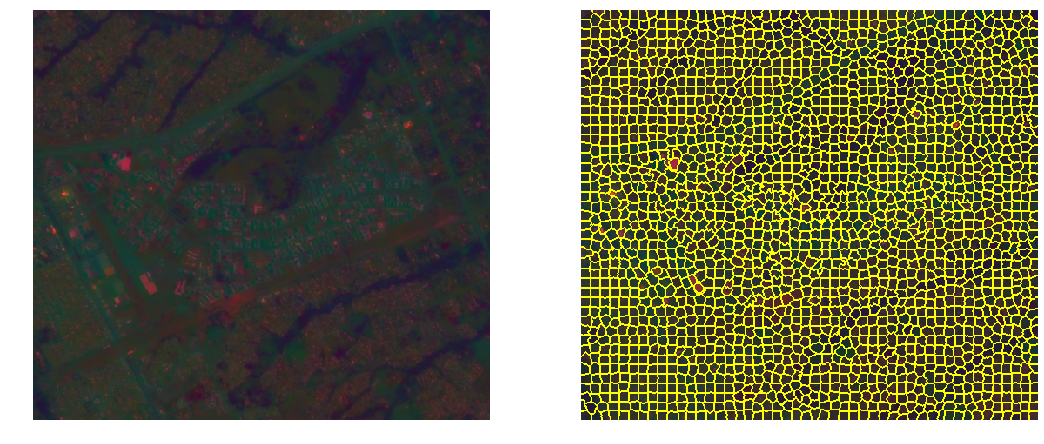

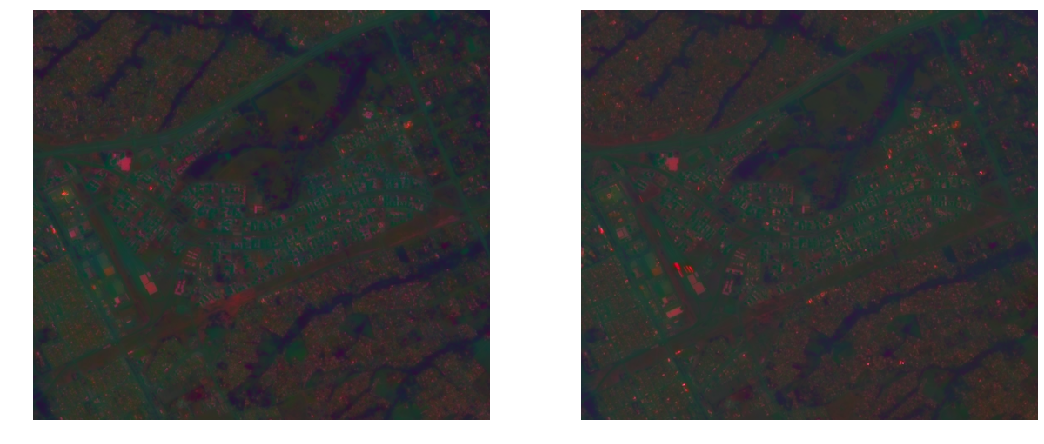

(471, 525, 3)


In [23]:
# computando o SLIC
from skimage import img_as_float
from skimage import segmentation
from skimage import color

aguasclaras_labels = segmentation.slic(aguasclaras_pca_t1, compactness=20, n_segments=2000, sigma=0)
aguasclaras_slic = color.label2rgb(aguasclaras_labels, aguasclaras_pca_t1, kind='avg')
show_compare(aguasclaras_pca_t1, segmentation.mark_boundaries(aguasclaras_pca_t1, aguasclaras_labels))
show_compare(aguasclaras_pca_t1, aguasclaras_pca_t2)
print(aguasclaras_pca_t2.shape)


Extraindo características dos segmentos de t1 e t2 e comparando-os

42.911543494205596


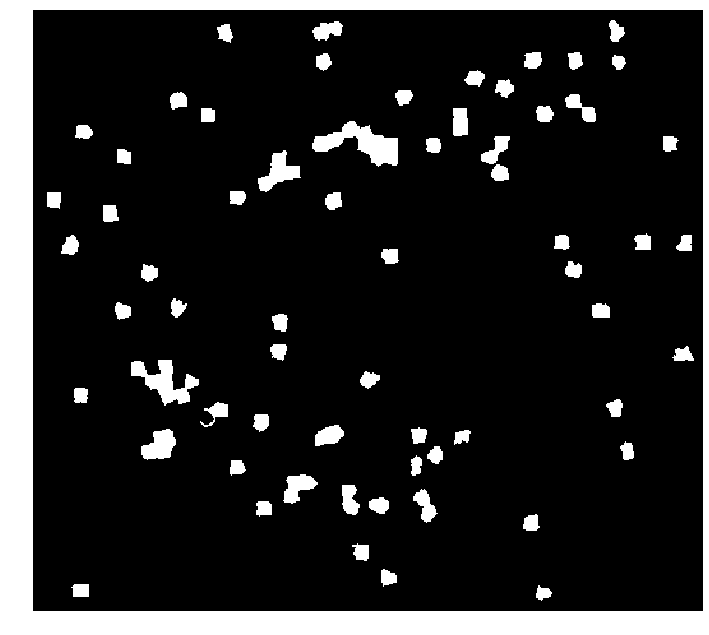

In [25]:
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops

# calcula 6 haralick features baseado em GLCM em t1 e em t2
# haralick = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
# glcm_angles = [np.radians(i*45) for i in range(4)] # 0º, 45º, 90º e 135º
# glcm_distances = [1, 2, 3] # distâncias de 1, 2 e 3 pixels

# aguasclaras_glcm_t1 = [greycomatrix(aguasclaras_pca_t1[:, :, c].astype(int), glcm_distances, glcm_angles, 256, symmetric=True, normed=True) for c in range(3)]
# aguasclaras_glcm_t1 = [list(map(lambda h: greycoprops(aguasclaras_glcm_t1[i], h), haralick)) for i in range(3)]
# aguasclaras_glcm_t1 = np.array(aguasclaras_glcm_t1)

# aguasclaras_glcm_t2 = [greycomatrix(aguasclaras_pca_t2[:, :, c].astype(int), glcm_distances, glcm_angles, 256, symmetric=True, normed=True) for c in range(3)]
# aguasclaras_glcm_t2 = [list(map(lambda h: greycoprops(aguasclaras_glcm_t2[i], h), haralick)) for i in range(3)]
# aguasclaras_glcm_t2 = np.array(aguasclaras_glcm_t2)


# calcula lbp em t1 e t2
lbp_radius = 2
lbp_points = lbp_radius * 8
lbp_method = 'nri_uniform'

aguasclaras_lbp_t1 = [local_binary_pattern(aguasclaras_pca_t1[:, :, band], lbp_points, lbp_radius, lbp_method) for band in range(3)]
aguasclaras_lbp_t1 = np.array(aguasclaras_lbp_t1)
aguasclaras_lbp_t1 = np.moveaxis(aguasclaras_lbp_t1, 0, -1)
aguasclaras_lbp_t2 = [local_binary_pattern(aguasclaras_pca_t2[:, :, band], lbp_points, lbp_radius, lbp_method) for band in range(3)]
aguasclaras_lbp_t2 = np.array(aguasclaras_lbp_t2)
aguasclaras_lbp_t2 = np.moveaxis(aguasclaras_lbp_t2, 0, -1)
# print(aguasclaras_lbp_t1.shape)
# show(aguasclaras_lbp_t1[:, :, 0])


# separa os pixels de cada segmento
aguasclaras_segments_total = np.max(aguasclaras_labels)
aguasclaras_segments_euclidean_difference = []
for segment_id in range(aguasclaras_segments_total):
    # seleciona apenas os pixels deste segmento
    segment_mask = aguasclaras_labels == segment_id
    segment_values_t1 = aguasclaras_lbp_t1[segment_mask]
    segment_values_t2 = aguasclaras_lbp_t2[segment_mask]
    
    # gera os histogramas da imagem lbp deste segmento para t1 e t2
    segment_max_t1 = segment_values_t1.max().astype(int)
    segment_max_t2 = segment_values_t2.max().astype(int)
    segment_bins = max(segment_max_t1, segment_max_t2) + 1
    segment_histogram_t1, _ = np.histogram(segment_values_t1, bins=segment_bins, range=(0, segment_bins))
    segment_histogram_t2, _ = np.histogram(segment_values_t2, bins=segment_bins, range=(0, segment_bins))

    # computa a distância euclidiana dos histogramas t1 e t2
    euclidian_distance = np.linalg.norm(segment_histogram_t1-segment_histogram_t2)
    aguasclaras_segments_euclidean_difference.append(euclidian_distance)



# acha um threshold = média + 1*desvio da distância euclidiana
aguasclaras_segments_euclidean_difference = np.array(aguasclaras_segments_euclidean_difference)
aguasclaras_segments_average = np.mean(aguasclaras_segments_euclidean_difference)
aguasclaras_segments_sigma = np.std(aguasclaras_segments_euclidean_difference)
aguasclaras_segment_threshold = aguasclaras_segments_average + aguasclaras_segments_sigma * 2
print(aguasclaras_segment_threshold)
import pandas as pd 
pd.DataFrame(aguasclaras_segments_euclidean_difference).to_csv("distances.csv")

# classifica em mudança/não-mudança
aguasclaras_segment_changed = list(map(lambda distance: distance > aguasclaras_segment_threshold, aguasclaras_segments_euclidean_difference))

aguasclaras_binary_map = np.ndarray(aguasclaras_labels.shape)
for segment_id in range(aguasclaras_segments_total):
    # seleciona apenas os pixels deste segmento
    segment_mask = aguasclaras_labels == segment_id
    aguasclaras_binary_map[segment_mask] = aguasclaras_segment_changed[segment_id]
aguasclaras_binary_map = aguasclaras_binary_map.astype(int)
show(aguasclaras_binary_map)


## Comparação com _ground truth_

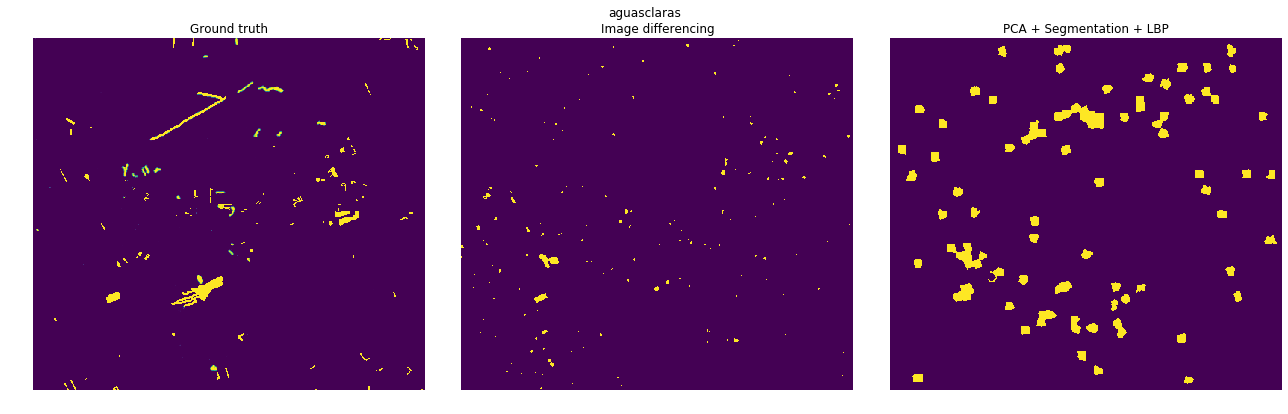

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
aguasclaras          0.9244783015601045   0.9765645536346174   0.9204219585038539   0.9359175007582651  


In [33]:
from skimage import measure

def show_compare_with_ground_truth(truth, result_image_differencing, result_pca_seg_lbp, title=''):
    fig, (truth_ax, result1_ax, result2_ax) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)
    truth_ax.imshow(truth)
    truth_ax.set_axis_off()
    truth_ax.set_title('Ground truth')
    result1_ax.imshow(result_image_differencing)
    result1_ax.set_axis_off()
    result1_ax.set_title('Image differencing')
    result2_ax.imshow(result_pca_seg_lbp)
    result2_ax.set_axis_off()
    result2_ax.set_title('PCA + Segmentation + LBP')
    fig.tight_layout()
    plt.show()
    
def get_comparison_indices(truth, test1_image, test2_image):
    ssim_1 = measure.compare_ssim(truth, test1_image)
    ssim_2 = measure.compare_ssim(truth, test2_image)
    difference_1 = abs(truth - test1_image)
    difference_2 = abs(truth - test2_image)
    different_pixels_1 = difference_1[difference_1 > 0].shape[0]
    different_pixels_2 = difference_2[difference_2 > 0].shape[0]
    all_pixels = truth.shape[0] * truth.shape[1]
    accuracy_1 = (all_pixels - different_pixels_1) / all_pixels
    accuracy_2 = (all_pixels - different_pixels_2) / all_pixels
    return {'ssim_1': ssim_1, 'accuracy_1': accuracy_1, 'ssim_2': ssim_2, 'accuracy_2': accuracy_2}

# mostra imagens
show_compare_with_ground_truth(aguasclaras_ground_truth, aguasclaras_difference_image, aguasclaras_binary_map, 'aguasclaras')

# mostra índice ssim e acurácia
aguasclaras_accuracy = get_comparison_indices(aguasclaras_ground_truth, aguasclaras_difference_image, aguasclaras_binary_map)
print("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Cidade','Differencing (ssim)','Differencing (acc)','PCA/seg/LBP (ssim)','PCA/seg/LBP (acc)'))
print("{:<20} {:<20} {:<20} {:<20} {:<20}".format('aguasclaras', aguasclaras_accuracy.get('ssim_1'), aguasclaras_accuracy.get('accuracy_1'), aguasclaras_accuracy.get('ssim_2'), aguasclaras_accuracy.get('accuracy_2')))
